# Fitting $R_t$ From COVID-19 Infection Data

This notebook was originally based off the `Realtime R0.ipynb` calculation, but intended to produce a Bayesian posterior over the values of $R_t$ *and* $\sigma$ given the data instead of only fitting $R_t$ using a max-likelihood estimate for $\sigma$.  It has now diverged significantly; the underlying model is fairly similar to `Realtime Rt mcmc.ipynb`, but our data handling differs in that we do not attempt to account for delays between infection, onset of symptoms, and confirmation.  Instead, we are estimating $R_t$ *of confirmation* (roughly, the delay time from infection to confirmation is one to two weeks---so our estimate will lag the infection $R_t$ by a week or two).  

We also employ a slightly different smoothing scheme (a causal exponential window with a decay rate of 7 days, to smooth out fluctuations on timescales shorter than (a) one week and (b) the serial timescale of the disease itself).  We use Stan to sample over the AR(1) prior for $R_t$ (increments are independent Gaussian variables) and also $\sigma$, the s.d. of the increment distribution. 

The [Stan](http://mc-stan.org) model we use for the sampling can be found in the `R0.stan` file in the current directory.

Note that our Python environment is captured in `environment.yml`; issuing
```zsh
conda env create -f environment.yml
```
should duplicate it on your system.  You can then activate it via 
```zsh
conda activate covid-19
```

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import datetime
import matplotlib.dates as md
import os
import os.path
import pandas as pd
import pystan
import seaborn as sns
from tqdm import tqdm

sns.set_context('notebook')
sns.set_palette('colorblind')

Download the dataset from https://covidtracking.com

In [3]:
url='https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

Compile the Stan model that simultaneously fits for $R_t$ and $\sigma$.  Our model differs from that in http://rt.live in several respects.  Trivially, we choose different priors on $\sigma$ (the scatter from one day to the next in the imposed prior on $R_t$), the first day's infection count, and $R_1$.  

Less trivially, http://rt.live assume that on day $i$ the expected number of positive tests is 
$$
\Lambda_i = k_{i-1} \exp\left( \frac{1 \, \mathrm{d}}{\tau} \left( R_i - 1 \right) \right),
$$
where $k_{i-1}$ is the *observed* number of positive tests in the previous day, $\tau$ is the serial time (the mean time between infectious cases), and $R_i$ is the time-dependent reproduction number at day $i$.  However, this is not quite the solution to an instantaneous SIR model; it assumes that the *actual* number of infected cases responsible infecting those on day $i$ is $k_{i-1}$, the *observed* number of cases from the day before.  Instead, an SIR solution---and the model in the Stan code below---would have 
$$
\Lambda_i = \Lambda_{i-1} \exp\left( \frac{1 \, \mathrm{d}}{\tau} \left( R_i - 1 \right) \right);
$$
that is, the expected cases in period $i$ depend on the expected cases in period $i-1$.  This change makes the fit less certain about the expected number of cases on day $i$ (since the observation, $k_{i-1}$ is assumed perfectly known, while the *expected* number of cases $\Lambda_{i-1}$ is, in turn, estimated from the previous day's data with uncertainty).  *Without stochastic sampling*, it would not be possible to fit this model, because the likelihoods on successive days are coupled to each other---so the approach in `Realtime R0.ipynb`, where each day's likelihood function is computed independently, would not be possible.  

Another major difference is that we marginalize over the serial number, using a log-normal distribution that matches a user-input mean and s.d.  See below.  This requires a somewhat strange parameterization, since otherwise $\tau$ and $R_t$ are very correlated, and we suffer from [Neal's funnel](https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html) as $\tau \to 0$; we sample in the $\Lambda_i$, and *derive* $R_t$ via 
$$
R_i = \tau \left( \log \Lambda_i - \log \Lambda_{i-1} \right) + 1
$$
(note that for small $R$ this can result in *negative* $R$).  To implement the AR(1) prior on the $R_t$, the model incorporates Jacobian factors to adjust the density for the sampling in $\Lambda_t$.

In [4]:
model = pystan.StanModel(file='R0.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2d77e15765b4eaf16b3de695fba4af NOW.


We marginalize over the serial time, based on the mean and standard deviation reported at https://epiforecasts.io/covid/ (which, in turn, come from [Nishiura, Linton, & Akhmetzhanov (2020)](https://doi.org/10.1101/2020.02.03.20019497)).

In [5]:
serial_mean = 4.7
serial_std = 2.9

## One State By Hand

Here we do my home state (NY) by hand, just to show aspects of the data processing, fitting, and plotting; stay tuned for the bulk run.

I chose to use an exponential filter with a longer constant for smoothing instead of a Gaussian filter with a 2-day time-constant as at http://rt.live (lately http://rt.live has been using a method for projecting cases back to time of onset that effectively filters on a ~7 day timescale; a discussion, including my rationale for not using that method, can be found [here](https://github.com/k-sys/covid-19/issues/43)).  I think a longer smoothing time constant is more appropriate for two reasons:
1. The amount of testing fluctuates between week and weekend (both because of supply and demand issues)
1. The serial time of the virus is ~7 days (assumed in the calculation below), so any given infected person is assumed able to infect others over 7 days.

This seems to eliminate the "oscillations" seen at http://rt.live (since it is smoothing on a longer timescale).

Based on the comment [here](https://github.com/k-sys/covid-19/issues/30), we use a one-sided exponential filter instead of centering.  The default choice of time constant (which we use) comes from the timescales at https://epiforecasts.io/covid/ for infection to symptoms (mean 5 d), symptoms to identification (mean 6.17 d from [here](http://virological.org/t/epidemiological-data-from-the-ncov-2019-outbreak-early-descriptions-from-publicly-available-data/337)), and 7 d because we expect weekly variation in testing for reasons unrelated to anything infection related.  This gives us a time constant ~10 d for smoothing.

Note that smoothing an exponential timeseries with another exponential *does not change the series timeconstant*, so we might think (hope?) that we are still estimating the local $R_t$ in this manner.

In [6]:
def running_exp_filter(xs, tau=sqrt(5*5 + 6.17*6.17 + 7*7)):
    y = 0.0
    ys = []
    a = exp(-1.0/tau)
    oma = -expm1(-1.0/tau)
    
    for x in xs:
        y = a*y + oma*x
        ys.append(y)
    
    return pd.Series(index=xs.index, data=ys)

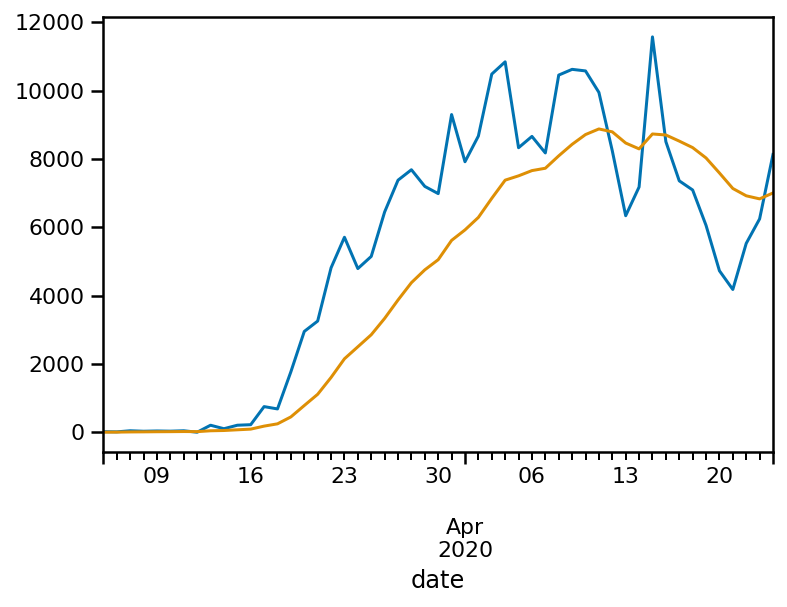

In [7]:
new_cases = states.loc['NY'].diff().dropna()
smooth_new_cases = running_exp_filter(new_cases, tau=7)

new_cases.plot()
smooth_new_cases.plot()

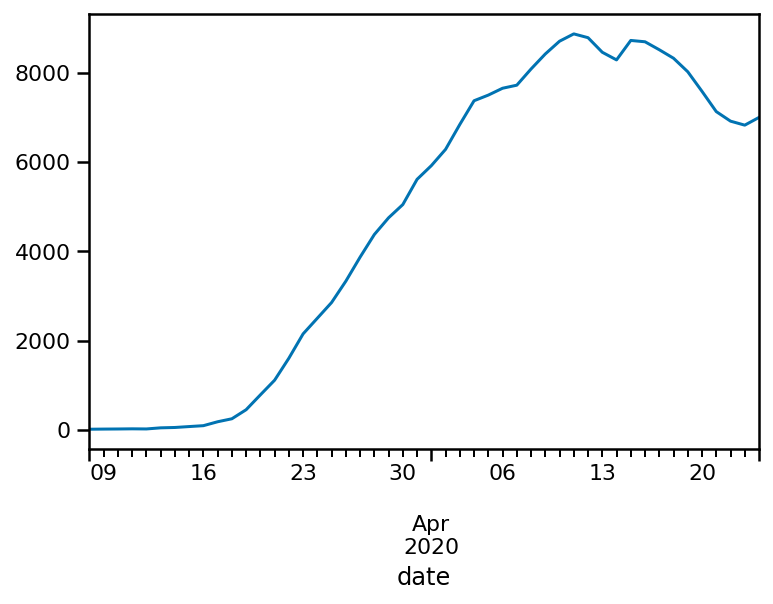

In [8]:
new_cases = states.loc['NY'].diff().dropna()
smooth_new_cases = running_exp_filter(new_cases, tau=7)
i10 = np.where(smooth_new_cases.gt(10))[0][0]
smooth_new_cases = smooth_new_cases.iloc[i10:]
smooth_new_cases.index = pd.to_datetime(smooth_new_cases.index)
smooth_new_cases.plot()

data = {
    'ndays': len(smooth_new_cases),
    'k': array(smooth_new_cases).astype(np.int),
    'tau_mean': serial_mean,
    'tau_std': serial_std
}

Run the fits, hinting to `arviz` that it should use the appropriate date-time coordinates for the expected number of counts and $R_t$.

In [9]:
fit_stan = model.sampling(data=data)
fit = az.from_pystan(fit_stan, 
                     coords={'exp_cts_dates': smooth_new_cases.index,
                             'Rt_dates': smooth_new_cases.index[1:]},
                     dims={'exp_cts': ['exp_cts_dates'],
                           'Rt': ['Rt_dates']})

A quick traceplot, just because it looks pretty:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119c489d0>,
      dtype=object)

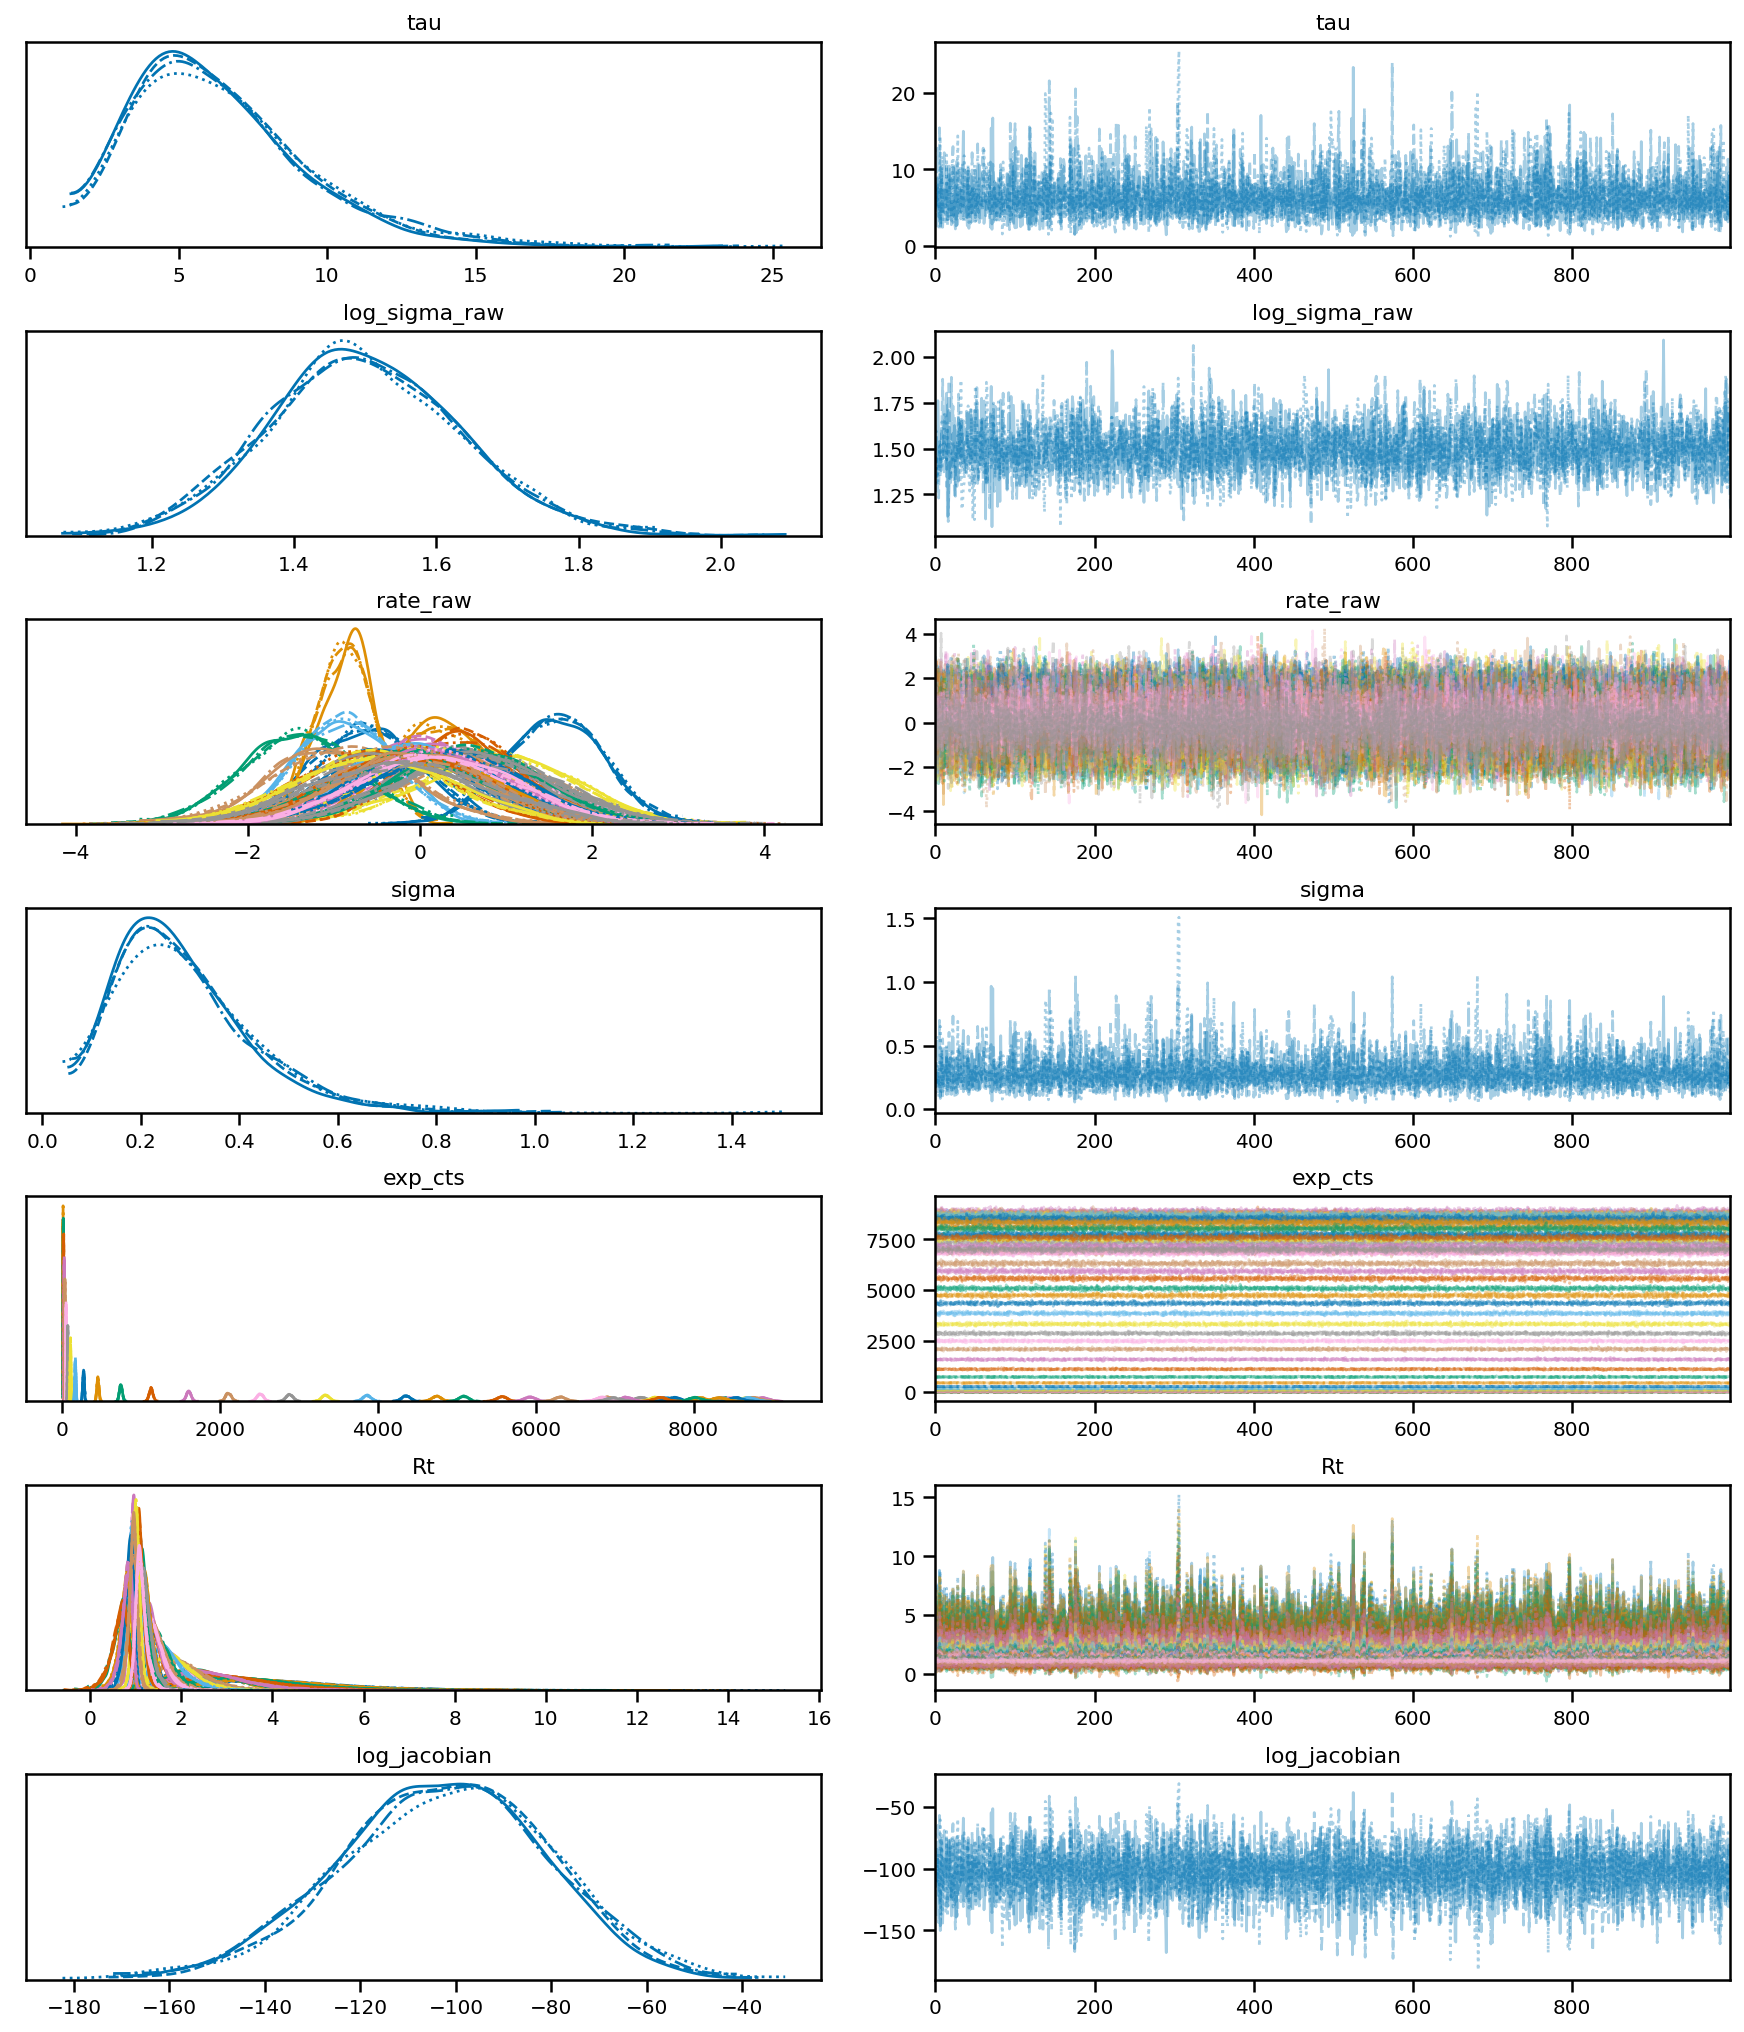

In [10]:
az.plot_trace(fit, compact=True)

(737490.7, 737541.3, 0.0, 5.0)

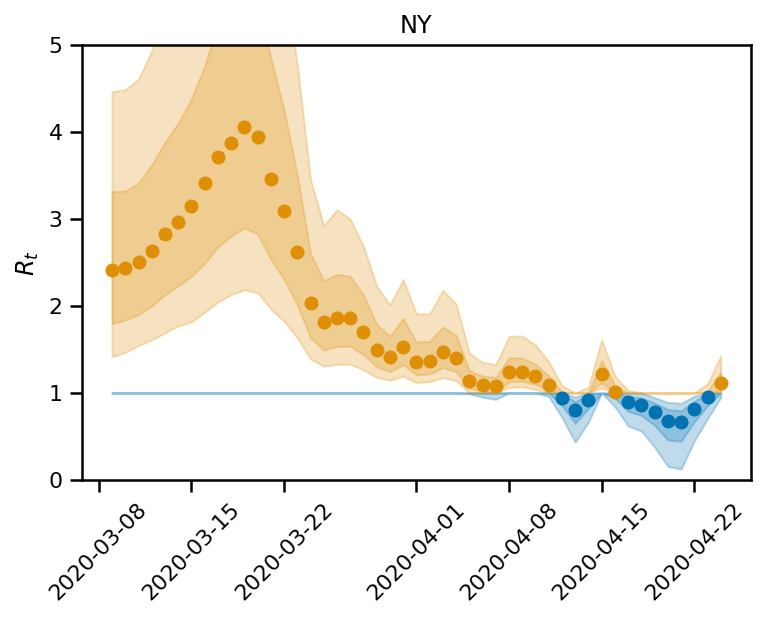

In [11]:
m = median(fit.posterior.Rt, axis=(0,1))
hh = percentile(fit.posterior.Rt, 97.5, axis=(0,1))
h = percentile(fit.posterior.Rt, 84, axis=(0,1))
l = percentile(fit.posterior.Rt, 16, axis=(0,1))
ll = percentile(fit.posterior.Rt, 2.5, axis=(0,1))

x = fit.posterior.Rt_dates.values

good_dates = m <= 1.0
bad_dates = m > 1.0

plot_date(x[good_dates], m[good_dates], xdate=True, color=sns.color_palette()[0])
fill_between(x, where(h<1, h, 1) , where(l<1, l, 1), alpha=0.25, color=sns.color_palette()[0])
fill_between(x, where(hh<1, hh, 1) , where(ll<1, ll, 1), alpha=0.25, color=sns.color_palette()[0])

plot_date(x[bad_dates], m[bad_dates], xdate=True, color=sns.color_palette()[1])
fill_between(x, where(h>1, h, 1) , where(l>1, l, 1), alpha=0.25, color=sns.color_palette()[1])
fill_between(x, where(hh>1, hh, 1) , where(ll>1, ll, 1), alpha=0.25, color=sns.color_palette()[1])

title('NY')

xticks(rotation=45)
ylabel(r'$R_t$')

axis(ymin=0, ymax=5)

## All States

In [7]:
def fit_state(states, state_key):
    new_cases = states.loc[state_key].diff().dropna()
    smooth_new_cases = running_exp_filter(new_cases, tau=7)
    i10 = np.where(smooth_new_cases.gt(10))[0][0]
    smooth_new_cases = smooth_new_cases.iloc[i10:]
    smooth_new_cases.index = pd.to_datetime(smooth_new_cases.index)

    data = {
        'ndays': len(smooth_new_cases),
        'k': array(smooth_new_cases).astype(np.int),
        'tau_mean': serial_mean,
        'tau_std': serial_std
    }
    
    tries = 0
    iter = 2000
    thin = 1
    while tries < 3:
        fit = az.from_pystan(model.sampling(data=data, iter=iter, thin=thin), 
                             coords={'exp_cts_dates': smooth_new_cases.index,
                                     'Rt_dates': smooth_new_cases.index[1:]},
                             dims={'exp_cts': ['exp_cts_dates'],
                                   'Rt': ['Rt_dates']})
        ess = az.ess(fit, var_names=['tau', 'sigma', 'exp_cts']).min()
        if ess.tau > 1e2 and ess.sigma > 1e2 and ess.exp_cts > 1e2 and np.all(az.bfmi(fit) > 0.2):
            break
        else:
            tries += 1
            iter *= 2
            thin *= 2
    
    return fit

We run the fit on each state (takes ten-twenty minutes on my MacBook); some states have no data, so we skip those.

In [8]:
state_fits = {}
with tqdm(states.groupby(level=0)) as bar:
    for st, _ in bar.iterable:
        try:
            if np.all(np.isnan(states.loc[st]) | (states.loc[st] == 0)):
                bar.write('Skipping state: {:s}'.format(st))
                bar.update(1)
                continue
            state_fits[st] = fit_state(states, st)
            bar.update(1)
        except (RuntimeError, IndexError):
            bar.write('State {:s} failed with RuntimeError; skipping'.format(st))
            bar.update(1)
            continue

  5%|▌         | 3/56 [00:57<14:27, 16.36s/it]

Skipping state: AS


 21%|██▏       | 12/56 [02:53<10:27, 14.26s/it]

State GU failed with RuntimeError; skipping


 48%|████▊     | 27/56 [06:38<08:44, 18.07s/it]

State MP failed with RuntimeError; skipping


 77%|███████▋  | 43/56 [10:05<02:10, 10.00s/it]

State PR failed with RuntimeError; skipping


 89%|████████▉ | 50/56 [11:29<01:13, 12.18s/it]

State VI failed with RuntimeError; skipping


100%|██████████| 56/56 [12:28<00:00, 13.36s/it]


Save all the fits; use `load_state_fits` (untested) to load them back in.

In [9]:
def save_state_fits(fits, directory):
    try:
        os.makedirs(directory)
    except OSError:
        pass
    
    for k, f in fits.items():
        az.to_netcdf(f, os.path.join(directory, k + '.nc'))
def load_state_fits(directory):
    fits = {}
    for f in glob.glob(os.path.join(directory, '*.nc')):
        k = os.path.splitext(os.path.split(f)[1])[0]
        fits[k] = az.from_netcdf(f)

In [10]:
save_state_fits(state_fits, 'state_fits')

And make a plot that is similar to the one at http://rt.live

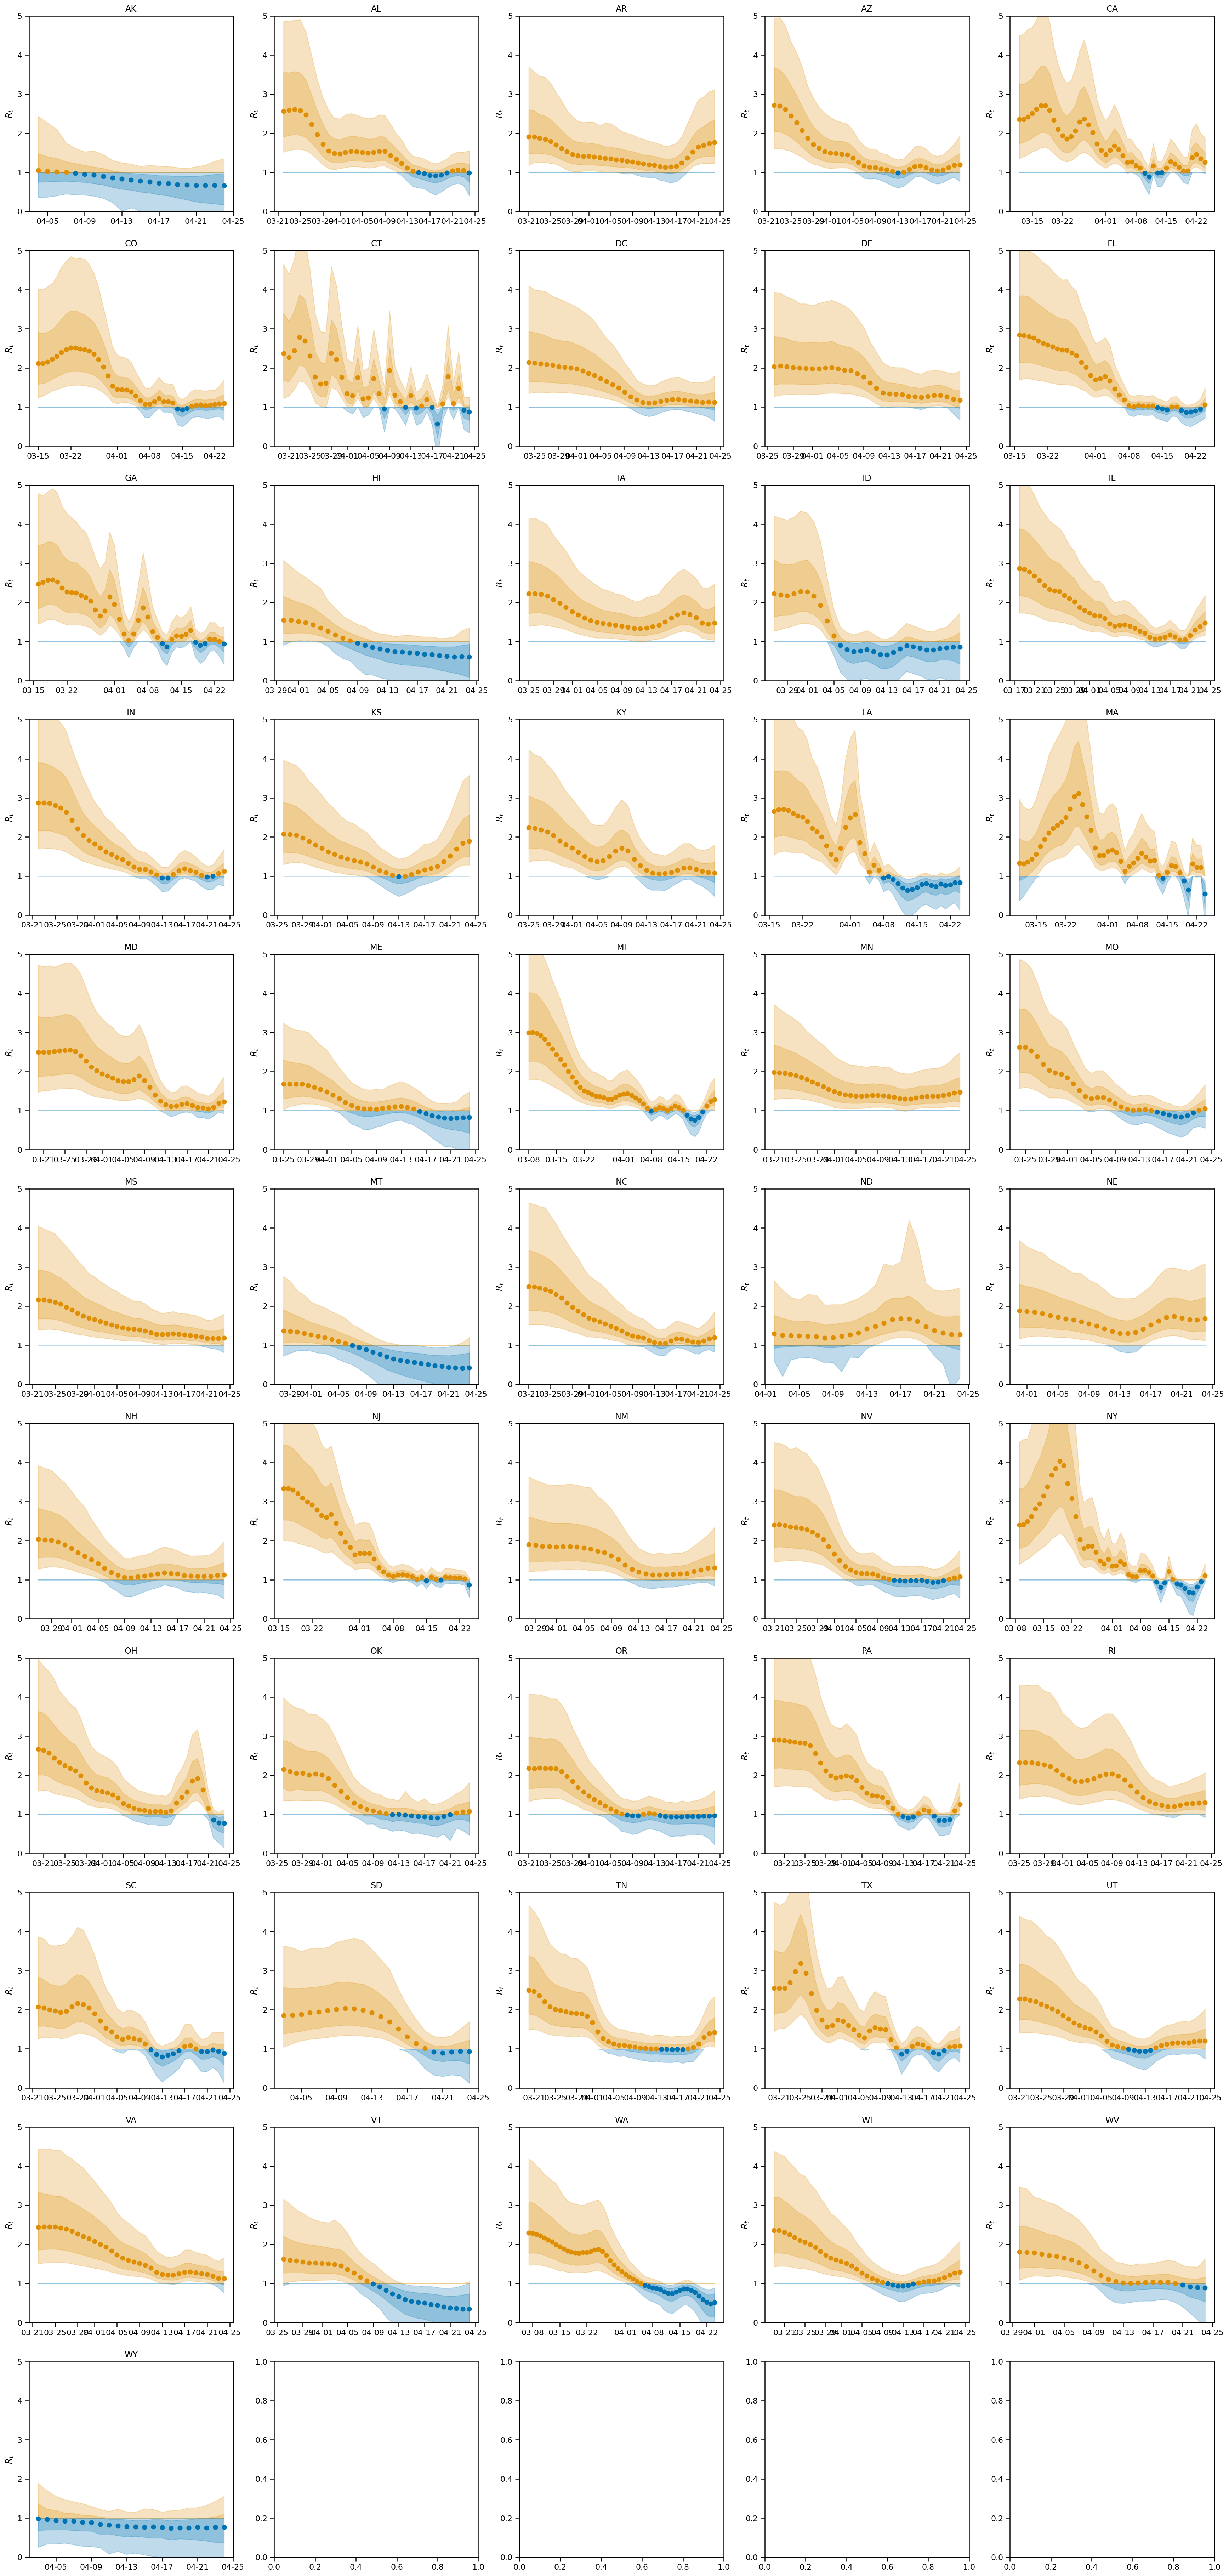

In [11]:
nc = 5
nr = 11

fig, axes = subplots(nrows=nr, ncols=nc, figsize=(30, 66))

for (k,fit), ax in zip(state_fits.items(), axes.flatten()):
    m = median(fit.posterior.Rt, axis=(0,1))
    hh = percentile(fit.posterior.Rt, 97.5, axis=(0,1))
    h = percentile(fit.posterior.Rt, 84, axis=(0,1))
    l = percentile(fit.posterior.Rt, 16, axis=(0,1))
    ll = percentile(fit.posterior.Rt, 2.5, axis=(0,1))

    x = fit.posterior.Rt_dates.values

    good_dates = m <= 1.0
    bad_dates = m > 1.0

    ax.plot_date(x[good_dates], m[good_dates], xdate=True, color=sns.color_palette()[0])
    ax.fill_between(x, where(h<1, h, 1) , where(l<1, l, 1), alpha=0.25, color=sns.color_palette()[0])
    ax.fill_between(x, where(hh<1, hh, 1) , where(ll<1, ll, 1), alpha=0.25, color=sns.color_palette()[0])

    ax.plot_date(x[bad_dates], m[bad_dates], xdate=True, color=sns.color_palette()[1])
    ax.fill_between(x, where(h>1, h, 1) , where(l>1, l, 1), alpha=0.25, color=sns.color_palette()[1])
    ax.fill_between(x, where(hh>1, hh, 1) , where(ll>1, ll, 1), alpha=0.25, color=sns.color_palette()[1])

    date_fmt = md.DateFormatter('%m-%d')
    ax.xaxis.set_major_formatter(date_fmt)
    
    ax.set_title(k)
    ax.set_ylabel(r'$R_t$')
    ax.set_ylim(0, 5)

Here is a nice plot that shows the distribution of $R_t$ at the latest day of sampling, ordered by its median value:

In [12]:
nc = 4
nd = 1000

d = {'state': [], 'Rt': []}
for k, f in state_fits.items():
    d = {'state': concatenate((d['state'], (k,)*(nc*nd))), 
         'Rt': concatenate((d['Rt'], f.posterior.Rt[:,:,-1].values.flatten()))}
df = pd.DataFrame(d)

sort_Rts = [median(fit.posterior.Rt[:,:,-1]) for fit in state_fits.values()]
state_order = array(list(state_fits.keys()))[argsort(sort_Rts)]

Compare to http://rt.live:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text major ticklabel objects>)

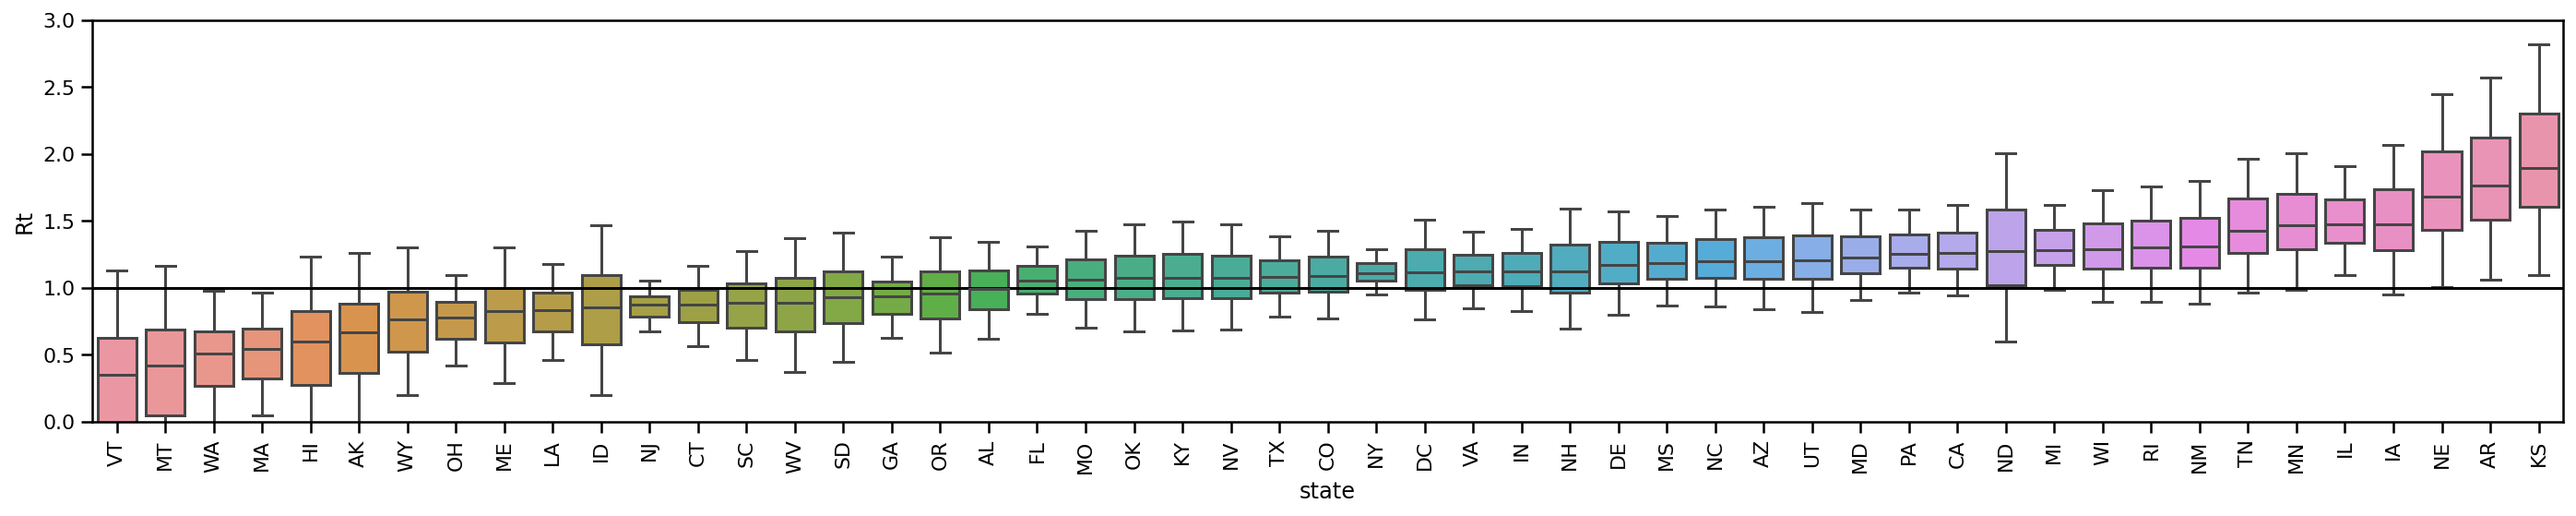

In [13]:
figure(figsize=(24,4))
sns.boxplot(x='state', y='Rt', data=df, order=state_order, fliersize=0, whis=1.0/1.35, )
axhline(1, color='k')
axis(ymin=0, ymax=3)
xticks(rotation=90)

In [ ]:
running_exp_filter(states['CT']).